In this notebook, we will write a code to gather velocity data from all the drives we have done so far.

In [9]:
from strym import strymread
import strym
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import time
import pickle

# Set the data folder and dbc file location for Toyota

In [2]:
parentfolder = "/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05"
dbcfile = '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc'

In [3]:
csvlist = []
folderlist = glob.glob(parentfolder+"*")
for datafolder in folderlist:
    csvlisttmp = glob.glob(datafolder+"/*.csv")
    for f in csvlisttmp:
        if "CAN" not in f:
            continue
        if "_5F" in f:
            continue
        csvlist.append(f)


# Read all the CSV file

In [4]:
speed_list = []
lead_distance_list = []
r_list = []
counter = 0
for csv in csvlist:
    print("\nReading the CSV file {}".format(csv))
    r = strymread(csvfile=csv, dbcfile=dbcfile)
    
    # Don't read the speed if data came in burst, basically filter out files which was recorded with Python
    if r.success == True :
        if r.burst:
            continue
        r_list.append(r)
        speed = r.speed()
        # if speed is empty
        if speed.shape[0] == 0:
            continue
        speed['Message'] = speed['Message']*0.277778
        lead_distance = r.get_ts(msg=869, signal="LEAD_DISTANCE")
        speed_list.append(speed)
        lead_distance_list.append(lead_distance)


Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-08-23-30-382135__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-13-21-29-803650__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-08-42-39-921531__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-09-09-59-241536__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-13-59-18-553197__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-10-11-35-602492__CAN_Messages.csv

Reading the CSV file /home/ivory/CyverseData/JmscslgroupData/PandaData/2020_03_05/2020-03-05-09-21-37-022653__CAN_Messages.csv


# Calculate Relative Velocity from Relative Distance

In [5]:
lead_distance_diff_list = []
resampled_state_list = []
for i, speed in enumerate(speed_list):
    if speed.shape[0] == 0:
        continue
    # now split the lead distance into chunks to get its derivative, 
    # we ignore the chunks with less than 5 data points
    
    lead_dist_chunks = strymread.create_chunks(lead_distance_list[i], plot = False)
    lead_dist_list = []
    lead_dist_diff_list = []
    for chunk in lead_dist_chunks:
        if chunk.shape[0] < 5:
            continue
        newdf = strym.differentiate(chunk, method="AE")
        lead_dist_diff_list.append(newdf)
        lead_dist_list.append(chunk)

    lead_dist = pd.concat(lead_dist_list)
    lead_dist_ = lead_dist.reset_index(drop=True)
    lead_dist_diff_AE = pd.concat(lead_dist_diff_list)
    lead_dist_diff_AE_ = lead_dist_diff_AE.reset_index(drop=True)
    lead_distance_diff_list.append(lead_dist_diff_AE_)
    # speed_new, lead_distance_new = strym.ts_sync(speed_list[i], lead_dist_, rate="second")
    
    resampled_state = pd.DataFrame()
    resampled_state['Time'] = lead_dist_['Time']
    resampled_state['Lead_Dist'] = lead_dist_['Message']
    resampled_state['Lead_Rel'] = lead_dist_diff_AE_['Message']
    resampled_state_list.append(resampled_state)

# Combine all list of resampled dataframe to a single dataframe

In [6]:
resampled_state_all = pd.concat(resampled_state_list)

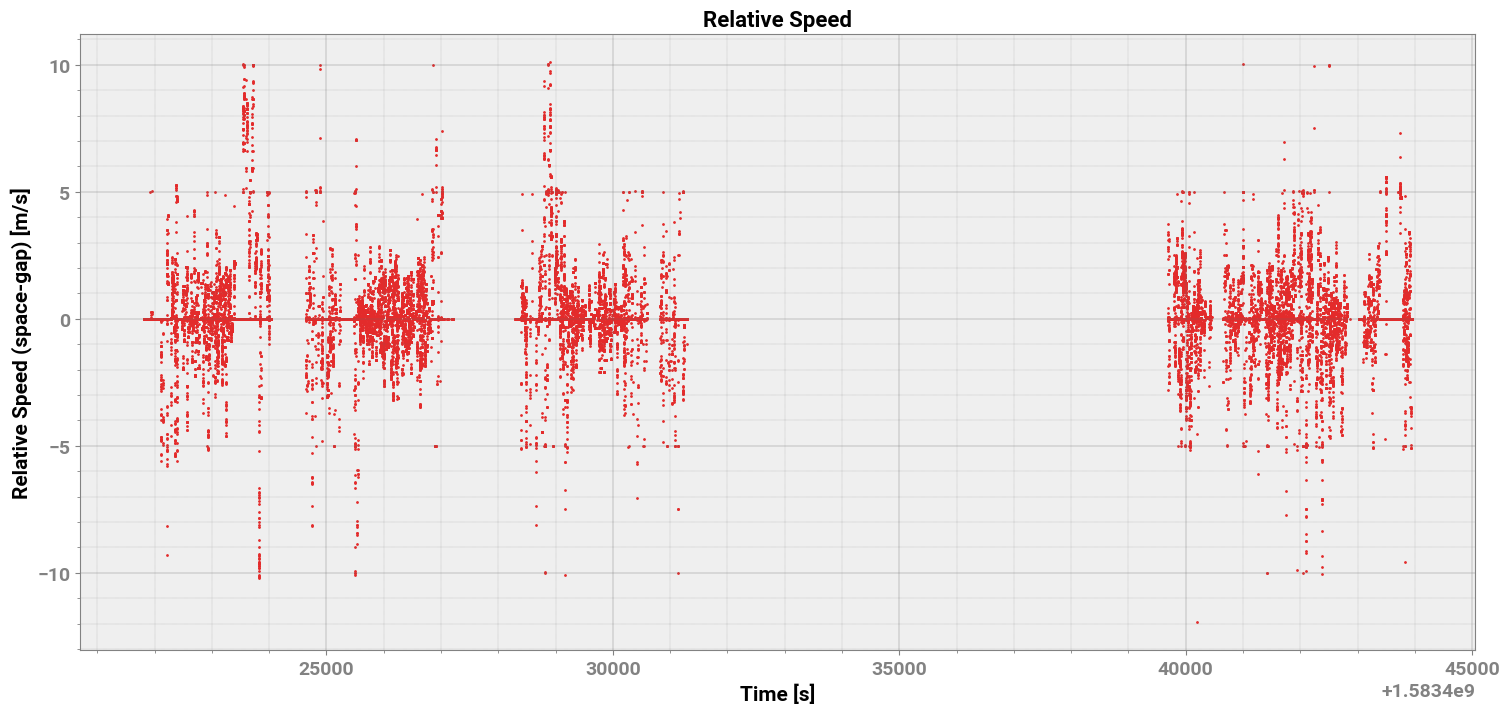

In [7]:
fig, ax = strym.create_fig(1)
ax[0].scatter(x = 'Time', y = 'Lead_Rel', data = resampled_state_all, s = 1, color = "#E32b2b")
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Relative Speed (space-gap) [m/s]')
ax[0].set_title('Relative Speed')
plt.show()

# Make a phase-space plot

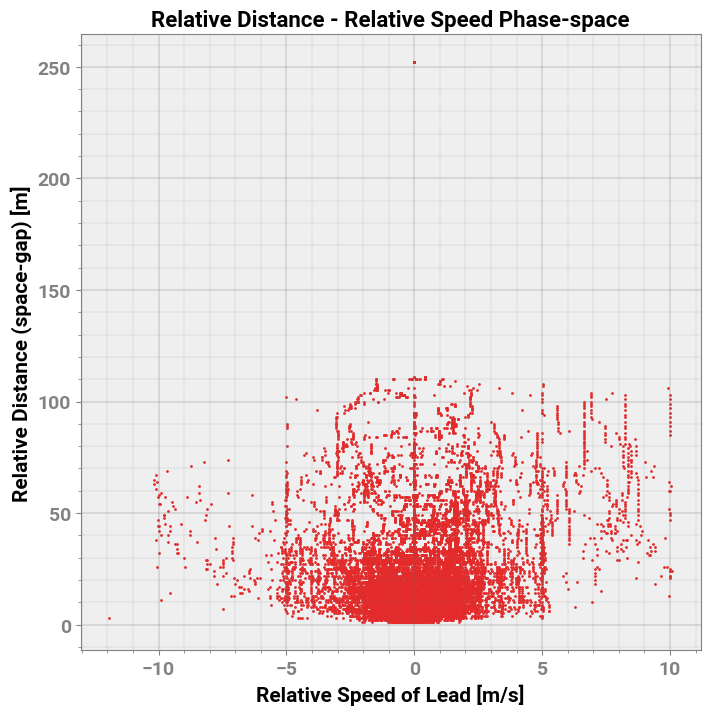

In [8]:
fig, ax = strym.create_fig(1)
fig.set_size_inches(8, 8)
ax[0].scatter(x = 'Lead_Rel', y = 'Lead_Dist', data = resampled_state_all, s = 1, color = "#E32b2b")
ax[0].set_xlabel('Relative Speed of Lead [m/s]')
ax[0].set_ylabel('Relative Distance (space-gap) [m]')
ax[0].set_title('Relative Distance - Relative Speed Phase-space')
plt.show()

In [10]:
dt_object = datetime.datetime.fromtimestamp(time.time())
dt = dt_object.strftime('%Y-%m-%d-%H-%M-%S-%f')
description = "_2020_03_05_relative_distance_relative_speed_Data"
fig.savefig(dt+ description + ".pdf", dpi = 300)
fig.savefig(dt+ description + ".png", dpi = 300)
pickle.dump(fig, open(dt+ description +".pickle", 'wb'))
variable_dictionary = {}
variable_dictionary['relative_distance_relative_speed'] = resampled_state_all.to_numpy()
sio.savemat(dt+"_2020_03_05_relative_distance_relative_speed_Data.mat", variable_dictionary)